## I. Load programs and data
In this part we load:
* Some functions from *job_title_processing* package + Python packages
* Dataset of annotated job offers. Data comes from [Pôle emploi API](https://www.emploi-store-dev.fr/portail-developpeur-cms/home/catalogue-des-api/documentation-des-api/api/api-offres-demploi-v2.html). They were collected in 2019 and are not open data for now.
* Data from the French occupation nomenclatura (ROME) wich provides for each occupation code a list of possible job titles (available [here](https://www.pole-emploi.org/opendata/repertoire-operationnel-des-meti.html?type=article))

### a. Load useful functions

In [1]:
# Python packages
import pickle, os, math
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
from sklearn import metrics

In [2]:
# Local job titles functions
from job_title_processing import JobOffersTitleLemmatizer, JobOffersTitleCleaner
from job_title_processing.tools.svm_classification import *
from job_title_processing.tools.utils import *

In [3]:
# Global params
ENCODING, SEP = "utf-8-sig", ";"
DOMAINS = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N']

In [19]:
# Graphical tools
%matplotlib inline
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib import gridspec

plt.rcParams['font.family'] = "DejaVu Sans"
plt.rcParams['font.size'] = 23

DOMAINS_PALETTE = [
    '#1F497D', '#C0504D', '#9BBB59', '#8064A2', '#6BB1C9' , '#CC6600', '#0066CC',
    '#A50021', '#62C400', '#5F37AF', '#4BACC6', '#F79646','#B7C0EF' ,'#E3A5A5'
]

### b. Load French data from a csv file

In [5]:
ROOT = load_root_path() # Package root
fr_folder = os.path.join(ROOT, "data", "FR")

# Load French data (API Pole emploi 2019 - NOT OPEN DATA)
file = os.path.join(fr_folder, "raw_data-poleemploi_2019-01-01_2019-12-31.csv")
columns = {'intitule':'title', 'romeCode':'ROME'}
pole_emploi = pd.read_csv(file, encoding=ENCODING, sep=SEP, usecols=columns.keys())
pole_emploi.rename(columns=columns, inplace=True)
pole_emploi['domain'] = pole_emploi.ROME.str[0]

# Load titles from official nomenclature
file = os.path.join(fr_folder, "ROME_label.csv")
columns = {'titre':'title', 'ROME':'ROME'}
nomenclature = pd.read_csv(file, encoding=ENCODING, sep=SEP)
nomenclature.rename(columns=columns, inplace=True)
nomenclature['domain'] = nomenclature.ROME.str[0]

# Merge data
data = pole_emploi.append(nomenclature, ignore_index=True)

## II. Explore data

In [7]:
print("Dataset size: " + str(len(data)))

Dataset size: 1558849


In [8]:
label_count = Counter(data.ROME)
print("Most represented label : " + str(label_count.most_common()[0]))
print("Less represented label : " + str(label_count.most_common()[-1]))
print("Mean samples per label : " + str(np.mean(list(label_count.values()))))

Most represented label : ('G1602', 43767)
Less represented label : ('B1401', 7)
Mean samples per label : 2930.1672932330825


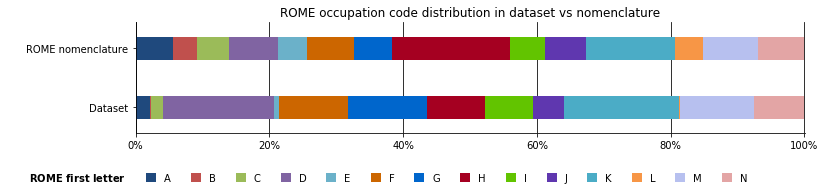

In [9]:
# Nomenclatura distribution
unique_nomanclature = nomenclature.drop_duplicates(subset=['ROME'])
pct_nomenclature = unique_nomanclature.domain.value_counts().div(len(unique_nomanclature)/100)
pct_nomenclature_T = pd.DataFrame(pct_nomenclature).T[DOMAINS].rename(index={"domain": "Nomenclature"})
# Pole emploi data distribution
pct_pole_emploi = pole_emploi.domain.value_counts().div(len(pole_emploi)/100)
pct_pole_emploi_T = pd.DataFrame(pct_pole_emploi).T[DOMAINS].rename(index={"domain": "Pole emploi"})
# Merge
df  = pct_pole_emploi_T.append(pct_nomenclature_T)

%matplotlib inline
# Init figure and grid
fig = plt.figure(2, figsize=(12, 3))
gs = gridspec.GridSpec(2, 1, height_ratios =[3, 1])

# Figure
ax = plt.subplot(gs[0])
ax = df.plot(kind='barh', stacked=True, color=DOMAINS_PALETTE, ax=ax, width=0.38, legend=None)
ax.set(title='ROME occupation code distribution in dataset vs nomenclature')
fig.patch.set_visible(False)

# Y Axis
ax.set_yticklabels(['Dataset', 'ROME nomenclature'])

# X axis
plt.axis([ 0, 100.1, None, None]) # X-axis limits
fmt = '%.0f%%' # Add percent
xticks = mtick.FormatStrFormatter(fmt)
ax.xaxis.set_major_formatter(xticks)
ax.xaxis.grid(color='k'), ax.set_axisbelow(True) # Add vertical lines

# Frame
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Legend
handles, labels = ax.get_legend_handles_labels()
ax_leg = plt.subplot(gs[1])
ax_leg.axis("off")
ax_leg.legend(
    [plt.plot([],marker="", ls="")[0]] + handles, ["$\\bf{ROME\ first\ letter}$"] + labels, loc='best', 
    bbox_to_anchor=(0.42, 0., 0.5, 0.5), borderaxespad=0., ncol=len(labels) + 1, markerscale=1, prop={'size': 10}, 
    handlelength=1, handleheight=1, frameon=False
)

plt.show()

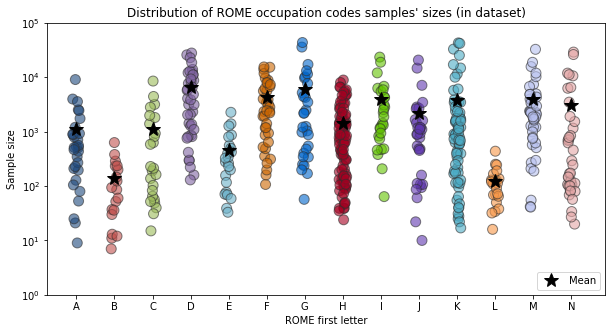

In [11]:
# Data distribution 
df_samples = pd.DataFrame.from_dict(label_count, orient='index', columns=['n_samples'])
df_samples['ROME'] = df_samples.index
df_samples = df_samples.reset_index(drop=True)
df_samples['domain'] = df_samples.ROME.str[0]

# Modify scale
df_samples['n_log'] = df_samples.n_samples.apply(math.log10)


# Init figure
f, ax = plt.subplots(figsize=(10, 5))

sns.stripplot(
    x="domain", y="n_samples", data=df_samples, alpha=.6, 
    order=DOMAINS, palette=DOMAINS_PALETTE, linewidth=1, size=10
)

# Param axis
ax.set(yscale="log", ylim=(1, 100000))
ax.minorticks_off()
ax.set(xlabel='ROME first letter', ylabel='Sample size')
ax.set(title='Distribution of ROME occupation codes samples\' sizes (in dataset)')

# Add mean number of samples per domain
for i, domain in enumerate(DOMAINS):
    df_domain = df_samples.loc[df_samples.dom==domain]
    mean_domain = np.mean(df_domain.n_samples)
    plt.plot(i, mean_domain, marker='*', markersize=15, color='black', zorder=i+3)

# Legend
star = mlines.Line2D([], [], color='black', marker='*', linestyle='None', markersize=15, label='Mean')
plt.legend(handles=[star],loc=4)

# Results
plt.show()

## III. Clean data and train linear SVM model

### a. Clean data
Data are cleaned following this process:
* lower case, delete digits and special char
* delete stopwords
* delete *jobwords* (eg. contract type, schedule, ..)
* remove location such as country, departement, region

In [12]:
cleaner = JobOffersTitleCleaner(language='FR', jobword=True, location=True)

In [13]:
cleaner.clean_str("Ingénieur à mi-temps en CDD")

'ingenieur'

In [14]:
cleaner.clean_str("Ingénieur à mi-temps en CDD en rhone alpes")

'ingenieur'

In [15]:
cleaner.clean_str("Ingénieur à mi-temps en CDD à Toulouse")

'ingenieur toulouse'

In [16]:
cleaner.clean_str("Maçon/Maçonne")

'macon maconne'

### b. Lemmatize data

Lemmatize job titles and keep only one occurence of each words in tite. **In the end, words order is mixed, since it doesn't matter here.**

In [17]:
lemmatizer = JobOffersTitleLemmatizer(language='FR', cleaner=cleaner)

In [18]:
lemmatizer.lemmatize_str("Maçon/Maçonne")

'macon'

In [325]:
lemmatizer.lemmatize_str("Ingénieur à mi-temps en CDD en rhone alpes")

'ingenieur'

In [334]:
lemmatizer.lemmatize_str("Aide comptable à mi-temps en CDD à Angers")

'angers comptable aider'

In [344]:
# TO UNCOMMENT
#
# X = lemmatizer.lemmatize_series(data.title)
# X_train, X_test, Y_train, Y_test = split(X, Y_pole_emploi, folder=fr_folder)

In [6]:
# Load lemmatized dataset
filename = os.path.join(fr_folder, "train_test.pickle")
with open(filename, 'rb') as f:
    X_train, X_test, Y_train, Y_test =  pickle.load(f)
    f.close()

### c. Train linear SVM model

In [ ]:
# TO UNCOMMENT
#
# Train model and save it
# svm = train_svm(X_train, Y_train, folder=fr_folder)  

In [7]:
# Load model
filename = os.path.join(fr_folder, "svm_C-1_mindf-1.pickle")
with open(filename, 'rb') as f:
    svm =  pickle.load(f)
    f.close()

## IV. Evaluate model

In [9]:
# Get global metrics at each level on test set
Y_pred = predict_svm(svm, X_test)

print("****** Level 1: ROME occupation code ******")
global_metrics_svm(Y_test, Y_pred, level=1)
print("\n ****** Level 2: occupation group ******\n")
global_metrics_svm(Y_test, Y_pred, level=2)
print("\n ****** Level 3: occupation domain ******\n")
global_metrics_svm(Y_test, Y_pred, level=3)

****** Level 1: ROME occupation code ******


C:\Users\claire.dumesnildemar\AppData\Local\conda\conda\envs\jocas\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy : 0.9243952518447225
              precision    recall  f1-score   support
micro avg      0.924395  0.924395  0.924395  311700.0
macro avg      0.871867  0.821244  0.840665  311700.0
weighted avg   0.924902  0.924395  0.924024  311700.0

 ****** Level 2: occupation group ******

Accuracy : 0.9436894449791466
              precision    recall  f1-score   support
micro avg      0.943689  0.943689  0.943689  311700.0
macro avg      0.890953  0.860490  0.873962  311700.0
weighted avg   0.943849  0.943689  0.943622  311700.0

 ****** Level 3: occupation domain ******

Accuracy : 0.9610747513634905
              precision    recall  f1-score   support
micro avg      0.961075  0.961075  0.961075  311700.0
macro avg      0.944363  0.927000  0.935344  311700.0
weighted avg   0.961004  0.961075  0.961010  311700.0


In [10]:
from job_title_processing.tools.svm_classification import group_by_accuracy

# Get accuracy by domains
domain = [code[0] for code in Y_test]
df = pd.DataFrame(list(zip(Y_test, Y_pred, domain)), columns=['Y_test', 'Y_pred', 'domain'])

# Get f1 scores by domains
ROME_acc_by_domaine, domaine_accuracy, mean_accuracy = group_by_accuracy(df, group_by="domain", values=DOMAINS)

# Get f1 by domains
ROME_f1_by_domaine, macro_f1, micro_f1 = group_by_f1(df, group_by="domain", values=DOMAINS)

C:\Users\claire.dumesnildemar\AppData\Local\conda\conda\envs\jocas\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\claire.dumesnildemar\AppData\Local\conda\conda\envs\jocas\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


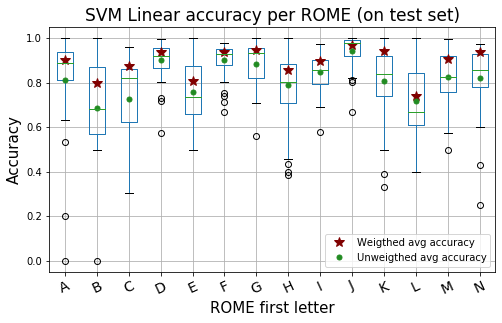

In [39]:
# Graphics
%matplotlib inline
f, ax = plt.subplots(figsize=(8, 5))
f.subplots_adjust(bottom=0.2)

# Agragated boxplots
ROME_acc_by_domaine.boxplot()
plt.xticks(rotation=25, fontsize=14)


# Add mean accuracy
for i, accuracy in enumerate(domaine_accuracy):
    plt.plot(i+1, accuracy, marker='*', markersize=10, color='maroon')
for i, accuracy in enumerate(mean_accuracy):
    plt.plot(i+1, accuracy, marker='.', markersize=10, color='forestgreen')

star = mlines.Line2D([], [], color='maroon', marker='*', linestyle='None', markersize=10, label='Weigthed avg accuracy')
dot = mlines.Line2D([], [], color='forestgreen', marker='.', linestyle='None', markersize=10, label='Unweigthed avg accuracy')

# Legend and axis
ax.legend(handles=[star, dot])
ax.set_xlabel('ROME first letter', fontsize = 15)
ax.set_ylabel('Accuracy', fontsize = 15)
ax.set_title('SVM Linear accuracy per ROME (on test set)',fontsize = 17)

file = os.path.join(ROOT, 'acc.png')
plt.savefig(file)

plt.show()

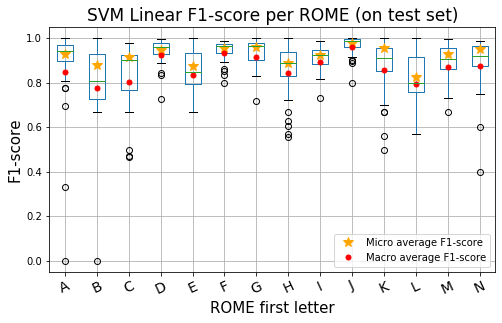

In [38]:
# Graphics
%matplotlib inline
f, ax = plt.subplots(figsize=(8, 5))
f.subplots_adjust(bottom=0.2)

ROME_f1_by_domaine.boxplot()
plt.xticks(rotation=25,fontsize=14)

# Add micro and macro F1
for i, f1 in enumerate(micro_f1):
    plt.plot(i+1, f1, marker='*', markersize=10, color='orange')
for i, f1 in enumerate(macro_f1):
    plt.plot(i+1, f1, marker='.', markersize=10, color='r')

star = mlines.Line2D([], [], color='orange', marker='*', linestyle='None', markersize=10, label='Micro average F1-score')
dot = mlines.Line2D([], [], color='r', marker='.', linestyle='None', markersize=10, label='Macro average F1-score')

# Legend and axis
ax.legend(handles=[star, dot])
ax.set_xlabel('ROME first letter', fontsize = 15)
ax.set_ylabel('F1-score', fontsize = 15)
ax.set_title('SVM Linear F1-score per ROME (on test set)',fontsize = 17)

file = os.path.join(ROOT, 'f1.png')
plt.savefig(file)

plt.show()

Normalized confusion matrix


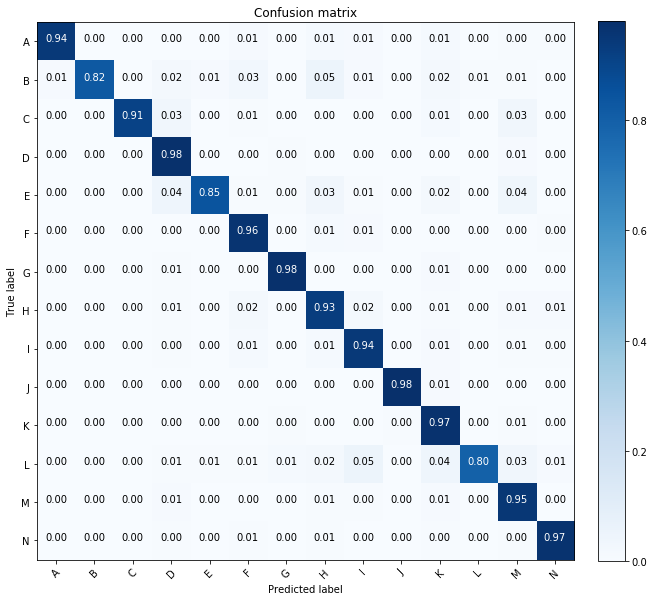

In [13]:
from job_title_processing.tools.svm_classification import plot_cm

# Confusion matrix
y_pred = [code[0] for code in Y_pred]
y_true = [code[0] for code in Y_test]

# Get confusion matrix
cm = metrics.confusion_matrix(y_true, y_pred, labels = sorted(list(set(y_true+y_pred))))

# Plot confusion matrix (re-evaluate it)
fig = plot_cm(y_true, y_pred,figsize=(9,9), normalize=True)
# file = os.path.join(ROOT, 'confusion.png')
# fig.savefig(file,dpi=fig.dpi, bbox_inches = "tight")